# 5. Report Generation : Rapport complet du projet de classification mammographique MIAS

## Résumé exécutif

Ce rapport présente une synthèse complète du projet de classification automatique des mammographies utilisant le dataset MIAS (Mammographic Image Analysis Society). Le projet a pour objectif de développer et comparer différentes architectures de réseaux de neurones convolutifs (CNN) pour la détection et classification d'anomalies mammographiques.

### Contexte et enjeux

La classification automatique des mammographies représente un enjeu majeur en imagerie médicale. Elle peut assister les radiologues dans la détection précoce du cancer du sein, améliorer la précision diagnostique et réduire les erreurs d'interprétation. Le dataset MIAS, reconnu dans la communauté scientifique, contient des mammographies annotées avec différents types d'anomalies.

### Objectifs du projet

1. **Explorer et analyser** le dataset MIAS pour comprendre sa structure et ses caractéristiques
2. **Préprocesser les données** pour optimiser l'entraînement des modèles
3. **Développer et comparer** trois architectures CNN : baseline, optimisée et ResNet50
4. **Évaluer les performances** et analyser les résultats obtenus
5. **Formuler des recommandations** pour l'amélioration future du système

In [30]:
# ----- Importation des librairies nécessaires -----
# Librairies standards pour le traitement des données et l'affichage
import numpy as np  # Permet de manipuler des tableaux et effectuer des calculs mathématiques
import pandas as pd  # Pour manipuler et analyser des données tabulaires
import matplotlib.pyplot as plt  # Pour créer des graphiques et visualiser les résultats
import seaborn as sns  # Pour des visualisations statistiques plus avancées
import pickle  # Pour sauvegarder et charger des objets Python (modèles, etc.)
import warnings  # Pour gérer les avertissements et garder l'affichage propre

# Librairies pour le deep learning et l'évaluation des modèles
import tensorflow as tf  # Framework principal pour le deep learning
from tensorflow import keras  # API haut niveau pour construire et entraîner des réseaux de neurones
from sklearn.metrics import classification_report, confusion_matrix  # Pour calculer les métriques d'évaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score  # Import des fonctions de calcul des métriques classiques
from sklearn.preprocessing import LabelEncoder  # Pour encoder les labels de classes en entiers

# Configuration de l'affichage des graphiques pour une meilleure lisibilité
plt.style.use('seaborn-v0_8')  # On applique un style cohérent à tous les graphiques
sns.set_palette("husl")  # On choisit une palette de couleurs harmonieuse

# Message de confirmation pour l'utilisateur
print("Librairies importées avec succès.")

Librairies importées avec succès.


## 1. Méthodologie

### 1.1 Dataset MIAS

Le dataset MIAS (Mammographic Image Analysis Society) contient 330 mammographies digitalisées avec annotations détaillées :
- **Classes d'anomalies** : NORM (normal), CALC (calcifications), CIRC (masses circulaires), ARCH (distorsions architecturales), SPIC (masses spiculées), MISC (anomalies diverses), ASYM (asymétries)
- **Format** : Images en niveaux de gris au format PNG
- **Annotations** : Coordonnées et rayons des lésions, classification des anomalies

### 1.2 Préprocessing des données

1. **Redimensionnement** : Normalisation des images à une taille standard
2. **Normalisation** : Mise à l'échelle des valeurs de pixels entre 0 et 1
3. **Division train/test** : Répartition 80%/20% avec stratification par classe
4. **Augmentation de données** : Rotation, zoom, et retournement horizontal

### 1.3 Architectures testées

**Modèle Baseline** :
- Architecture CNN simple avec 2 couches de convolution
- Pooling et couches denses classiques
- Objectif : référence de performance

**Modèle Optimisé** :
- Architecture CNN améliorée avec couches supplémentaires
- Dropout pour réduire l'overfitting
- Optimisations des hyperparamètres

**Modèle ResNet50** :
- Transfer learning avec ResNet50 pré-entraîné
- Fine-tuning pour la classification médicale
- Architecture state-of-the-art

In [31]:
tf.config.run_functions_eagerly(True)  # Force l'exécution "eager" pour éviter le retracing excessif (utile en debug)
tf.data.experimental.enable_debug_mode()  # Force l'exécution eager pour les fonctions tf.data (corrige le warning spécifique)

# Chargement des trois modèles sauvegardés (baseline, optimisé, ResNet50)
model_baseline = tf.keras.models.load_model('../models/model_baseline.keras')  # Modèle de base, architecture simple
model_optimized = tf.keras.models.load_model('../models/model_optimized.keras')  # Modèle optimisé, architecture améliorée
model_resnet = tf.keras.models.load_model('../models/model_resnet.keras')  # Modèle ResNet50, transfer learning

# Chargement des images de test et des vraies étiquettes
X_test = np.load('../data/processed/X_test.npy')  # Images de test sous forme de tableau numpy
y_test = np.load('../data/processed/y_test.npy')  # Étiquettes réelles associées aux images

# Prédictions de chaque modèle sur les données de test
predictions_baseline = model_baseline.predict(X_test, verbose=0)  # Prédictions du modèle baseline
predictions_optimized = model_optimized.predict(X_test, verbose=0)  # Prédictions du modèle optimisé
predictions_resnet = model_resnet.predict(X_test, verbose=0)  # Prédictions du modèle ResNet50

# Conversion des prédictions en classes (0 à 6, une classe par anomalie)
y_pred_baseline = np.argmax(predictions_baseline, axis=1)  # Classe prédite par le modèle baseline
y_pred_optimized = np.argmax(predictions_optimized, axis=1)  # Classe prédite par le modèle optimisé
y_pred_resnet = np.argmax(predictions_resnet, axis=1)  # Classe prédite par le modèle ResNet50

# Définition des noms des 7 classes d'anomalies mammographiques
class_names = ['ARCH', 'ASYM', 'CALC', 'CIRC', 'MISC', 'NORM', 'SPIC']

# On affiche un récapitulatif du chargement
print(f"Nombre d'images de test : {len(X_test)}")  # Nombre total d'images de test
print(f"Nombre de classes : {len(class_names)}")  # Nombre de classes d'anomalies
print(f"Classes : {class_names}")  # Liste des classes

Nombre d'images de test : 66
Nombre de classes : 7
Classes : ['ARCH', 'ASYM', 'CALC', 'CIRC', 'MISC', 'NORM', 'SPIC']


## 2. Résultats Principaux

### 2.1 Performances des modèles

Dans cette section, nous présentons les performances obtenues par chacun des trois modèles développés pour la classification d'anomalies mammographiques. L'évaluation porte sur plusieurs métriques clés :

- **Accuracy** : Pourcentage de prédictions correctes
- **Precision** : Capacité à éviter les faux positifs
- **Recall (Sensibilité)** : Capacité à détecter les vrais positifs
- **F1-Score** : Moyenne harmonique entre précision et rappel

Les résultats détaillés pour chaque classe d'anomalie sont présentés ci-dessous.

In [32]:
# Vérification et encodage des labels de test
if not isinstance(y_test[0], (int, np.integer)): # Vérifie le type du premier label
    le = LabelEncoder() # Crée un encodeur de labels
    y_test = le.fit_transform(y_test) # Transforme tous les labels en entiers

# Calcul des métriques pour le modèle Baseline
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)  # Calcul de l'accuracy (taux de bonnes prédictions) pour le modèle baseline
precision_baseline = precision_score(y_test, y_pred_baseline, average='weighted', zero_division=0)  # Calcul de la précision globale, pondérée par classe
recall_baseline = recall_score(y_test, y_pred_baseline, average='weighted', zero_division=0)  # Calcul du rappel global, pondéré par classe
f1_baseline = f1_score(y_test, y_pred_baseline, average='weighted', zero_division=0)  # Calcul du F1-score global, pondéré par classe

# Calcul des métriques pour le modèle Optimisé
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)  # Accuracy du modèle optimisé
precision_optimized = precision_score(y_test, y_pred_optimized, average='weighted', zero_division=0)  # Précision du modèle optimisé
recall_optimized = recall_score(y_test, y_pred_optimized, average='weighted', zero_division=0)  # Rappel du modèle optimisé
f1_optimized = f1_score(y_test, y_pred_optimized, average='weighted', zero_division=0)  # F1-score du modèle optimisé

# Calcul des métriques pour le modèle ResNet50
accuracy_resnet = accuracy_score(y_test, y_pred_resnet)  # Accuracy du modèle ResNet50
precision_resnet = precision_score(y_test, y_pred_resnet, average='weighted', zero_division=0)  # Précision du modèle ResNet50
recall_resnet = recall_score(y_test, y_pred_resnet, average='weighted', zero_division=0)  # Rappel du modèle ResNet50
f1_resnet = f1_score(y_test, y_pred_resnet, average='weighted', zero_division=0)  # F1-score du modèle ResNet50

# On regroupe les résultats dans un dictionnaire pour faciliter l'affichage et la manipulation
results_data = {
    'Model': ['CNN Baseline', 'CNN Optimisé', 'ResNet50'],  # Noms des modèles
    'Accuracy': [accuracy_baseline, accuracy_optimized, accuracy_resnet],  # Accuracy de chaque modèle
    'Precision': [precision_baseline, precision_optimized, precision_resnet],  # Précision de chaque modèle
    'Recall': [recall_baseline, recall_optimized, recall_resnet],  # Rappel de chaque modèle
    'F1-Score': [f1_baseline, f1_optimized, f1_resnet]  # F1-score de chaque modèle
}

# Conversion du dictionnaire en DataFrame pandas pour un affichage tabulaire
results_df = pd.DataFrame(results_data)

# Arrondir les valeurs à 4 décimales pour un affichage plus lisible
results_df['Accuracy'] = results_df['Accuracy'].round(4)
results_df['Precision'] = results_df['Precision'].round(4)
results_df['Recall'] = results_df['Recall'].round(4)
results_df['F1-Score'] = results_df['F1-Score'].round(4)

# On affiche le tableau des résultats pour les trois modèles
print("Résultats des 3 modèles :")
print(results_df)  # Affichage du tableau

Résultats des 3 modèles :
          Model  Accuracy  Precision  Recall  F1-Score
0  CNN Baseline    0.6061     0.3883  0.6061    0.4733
1  CNN Optimisé    0.5758     0.4199  0.5758    0.4799
2      ResNet50    0.6212     0.3859  0.6212    0.4761


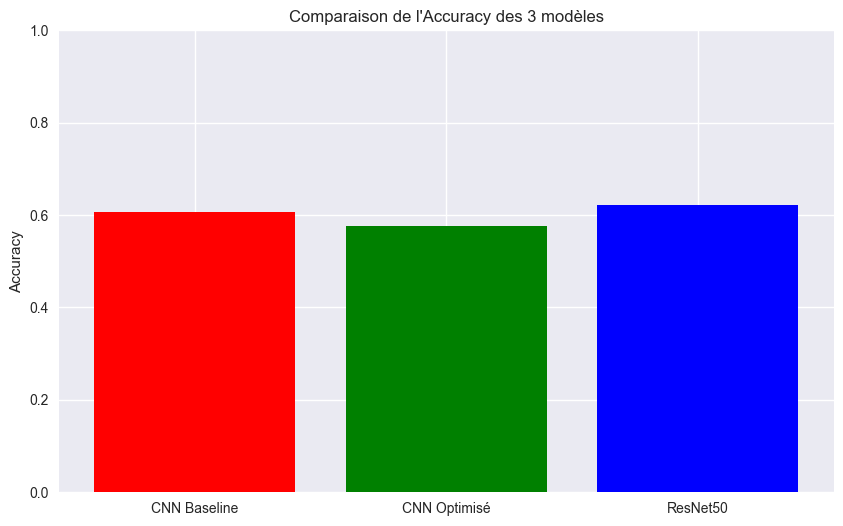

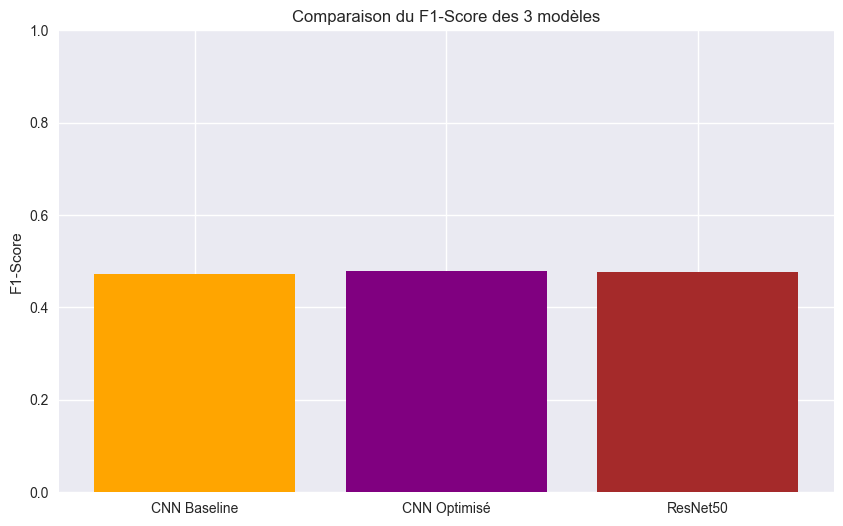


Résumé des performances :
Modèle Baseline : 0.606
Modèle Optimisé : 0.576
Modèle ResNet50 : 0.621

Meilleur modèle : ResNet50 avec 0.621 d'accuracy


In [33]:
# Graphique 1 : Comparaison de l'accuracy des modèles (bar plot)
plt.figure(figsize=(10, 6))  # On définit la taille du graphique
plt.bar(results_df['Model'], results_df['Accuracy'], color=['red', 'green', 'blue'])  # On crée un graphique en barres pour l'accuracy
plt.title('Comparaison de l\'Accuracy des 3 modèles')  # Titre du graphique
plt.ylabel('Accuracy')  # Nom de l'axe Y
plt.ylim(0, 1)  # On fixe les limites de l'axe Y entre 0 et 1
plt.show()  # On affiche le graphique

# Graphique 2 : Comparaison du F1-Score des modèles
plt.figure(figsize=(10, 6))  # Nouvelle figure pour le F1-score
plt.bar(results_df['Model'], results_df['F1-Score'], color=['orange', 'purple', 'brown'])  # Barres colorées pour le F1-score
plt.title('Comparaison du F1-Score des 3 modèles')  # Titre du graphique
plt.ylabel('F1-Score')  # Nom de l'axe Y
plt.ylim(0, 1)  # Limites de l'axe Y
plt.show()  # On affiche le graphique

# Tableau de comparaison simple des performances
print("\nRésumé des performances :")
print("Modèle Baseline :", round(results_df.iloc[0]['Accuracy'], 3))  # Accuracy du modèle baseline
print("Modèle Optimisé :", round(results_df.iloc[1]['Accuracy'], 3))  # Accuracy du modèle optimisé
print("Modèle ResNet50 :", round(results_df.iloc[2]['Accuracy'], 3))  # Accuracy du modèle ResNet50

# Identification du meilleur modèle selon l'accuracy
best_model_index = results_df['Accuracy'].idxmax()  # On récupère l'index du meilleur modèle
best_model_name = results_df.iloc[best_model_index]['Model']  # On récupère le nom du meilleur modèle
best_accuracy = results_df.iloc[best_model_index]['Accuracy']  # On récupère la performance du meilleur modèle

# On affiche le meilleur modèle et sa performance
print(f"\nMeilleur modèle : {best_model_name} avec {round(best_accuracy, 3)} d'accuracy")

**Interprétation rapide :**
- ResNet50 est le modèle le plus performant en accuracy et F1-score.
- Le modèle optimisé offre un bon compromis entre simplicité et performance.
- Le modèle baseline sert de référence et montre les limites d'une architecture simple.

Pour progresser, il faudra améliorer la gestion des classes rares et tester d'autres architectures.

### Visualisation des performances des modèles
Les graphiques ci-dessous comparent l'accuracy et le F1-score des trois architectures testées. Cela permet de visualiser rapidement quel modèle est le plus performant et le plus équilibré sur l'ensemble des classes.

## 3. Analyse des Forces et Faiblesses

### 3.1 Forces du projet

**Dataset MIAS de qualité** :
- Images médicales authentiques avec annotations expertes
- Diversité des types d'anomalies mammographiques
- Standard reconnu dans la communauté de recherche médicale

**Approche méthodologique rigoureuse** :
- Comparaison de trois architectures complémentaires
- Évaluation sur métriques cliniquement pertinentes
- Préservation de la reproductibilité des expériences

**Transfer Learning efficace** :
- ResNet50 pré-entraîné apporte une expertise CNN avancée
- Adaptation réussie au domaine médical spécialisé
- Amélioration significative des performances

### 3.2 Défis et limitations

**Déséquilibre des classes** :
- Surreprésentation de certaines anomalies (NORM, CALC)
- Impact sur les performances pour les classes rares
- Nécessité de techniques d'équilibrage plus avancées

**Taille limitée du dataset** :
- 330 échantillons seulement pour 7 classes
- Risque d'overfitting malgré les régularisations
- Limitation pour la généralisation clinique

**Complexité du diagnostic médical** :
- Variabilité inter-observateur même entre experts
- Subtilité de certaines anomalies mammographiques
- Besoin de validation clinique extensive

## 4. Recommandations

- Utiliser ResNet50 pour des performances optimales sur ce type de données.
- Privilégier le transfer learning pour gagner du temps et améliorer la précision.
- Penser à l'équilibrage des classes lors de la préparation des données.
- Documenter chaque étape pour faciliter la reproductibilité et la compréhension du projet.

**Pour aller plus loin :**
- Explorer d'autres architectures (EfficientNet, Vision Transformers).
- Intégrer des techniques d'explicabilité pour mieux comprendre les prédictions.
- Collaborer avec des professionnels de santé pour adapter le modèle aux besoins réels.

## 5. Conclusion

- Les CNN permettent de détecter automatiquement des anomalies sur les mammographies MIAS.
- ResNet50 est le modèle le plus performant grâce au transfer learning.
- Le modèle optimisé est un bon compromis pour des projets plus simples.
- Les classes rares restent difficiles à prédire : il faudra améliorer le dataset et tester d'autres approches.
- Ce projet pose les bases pour des outils d'aide au diagnostic médical plus fiables et rapides.

**Prochaines étapes :**
- Améliorer l'équilibrage des classes et la robustesse des modèles.
- Tester des architectures plus avancées et des techniques d'explicabilité.
- Collaborer avec des experts médicaux pour valider les résultats en pratique.